In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip

In [ ]:
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X2.zip

In [ ]:
!unzip /kaggle/working/DIV2K_train_HR.zip

In [ ]:
!unzip /kaggle/working/DIV2K_train_LR_bicubic_X2.zip

In [ ]:
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X2.zip

In [ ]:
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip

In [ ]:
!unzip /kaggle/working/DIV2K_valid_HR.zip

In [ ]:
!unzip /kaggle/working/DIV2K_valid_LR_bicubic_X2.zip

In [11]:
import torch
import cv2
import matplotlib.pyplot as plt
import PIL
import os

In [12]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image

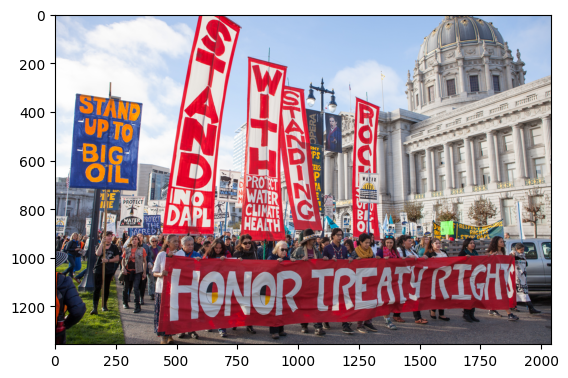

In [13]:
test_img = Image.open('/kaggle/working/DIV2K_train_HR/0206.png')
plt.imshow(test_img)

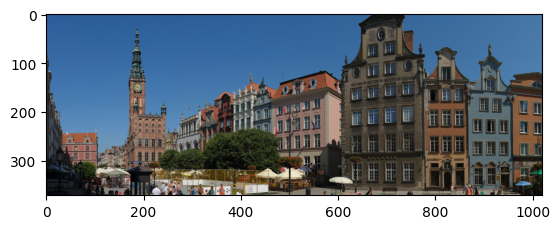

In [14]:
test_lr_img = Image.open('/kaggle/working/DIV2K_train_LR_bicubic/X2/0340x2.png')
plt.imshow(test_lr_img)

In [15]:
def double_size(image):
  transform = transforms.Compose([
      transforms.Resize((image.height * 2, image.width * 2), interpolation = Image.BICUBIC)
  ])
  return transform(image)

In [17]:
def count_item(path):
  i = 0
  for item in os.listdir(path):
    i = i + 1
  return i

In [16]:
#Test path of an image in High-resolution dataset
i = 0
for path in os.listdir('/kaggle/working/DIV2K_train_HR'):
  print(path)
  i = i + 1
  if i > 3:
    break

0206.png
0288.png
0047.png
0740.png


In [19]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
    #Normalization
])

In [20]:
class SRCNN_Dataset(Dataset):
  def __init__(self, hr_dir, lr_dir, transform, double_size):
    self.hr_dir = hr_dir
    self.lr_dir = lr_dir
    self.transform = transform
    self.double_size = double_size

  def __len__(self):
    return count_item(self.hr_dir)

  def __getitem__(self, idx):
    list_hr = os.listdir(self.hr_dir)
    list_lr = os.listdir(self.lr_dir)

    list_hr.sort() #Sort để duyệt file theo đúng thứ tự tương ứng
    list_lr.sort()

    hr_img_name = list_hr[idx]
    lr_img_name = list_lr[idx]

    hr_img_path = self.hr_dir + '/' + hr_img_name
    lr_img_path = self.lr_dir + '/' + lr_img_name

    hr_img = Image.open(hr_img_path)
    lr_img = Image.open(lr_img_path)

    lr_img = self.transform(double_size(lr_img))

    hr_img = self.transform(hr_img)

    return (lr_img, hr_img)




In [21]:
train_hr_path = '/kaggle/working/DIV2K_train_HR'
train_lr_path = '/kaggle/working/DIV2K_train_LR_bicubic/X2'

train_dataset = SRCNN_Dataset(train_hr_path, train_lr_path, data_transform, double_size)

In [22]:
print(len(train_dataset))

800


In [23]:
print(train_dataset.__getitem__(1)[1].shape)
print(train_dataset.__getitem__(1)[0].shape)

torch.Size([3, 1848, 2040])
torch.Size([3, 1848, 2040])


In [24]:
test_hr_path = '/kaggle/working/DIV2K_valid_HR'
test_lr_path = '/kaggle/working/DIV2K_valid_LR_bicubic/X2'

test_dataset = SRCNN_Dataset(test_hr_path, test_lr_path, data_transform, double_size)

In [25]:
print(len(test_dataset))

100


In [26]:
print(test_dataset.__getitem__(1)[0].shape)
print(test_dataset.__getitem__(1)[1].shape)

torch.Size([3, 1356, 2040])
torch.Size([3, 1356, 2040])


In [27]:
train_data_loader = DataLoader(train_dataset, batch_size = 1, shuffle= True, num_workers = 0)

test_data_loader = DataLoader(test_dataset, batch_size = 1, shuffle = False)

In [34]:
for batch, (X, y) in enumerate(train_data_loader):
    if batch > 10 :
        break
    print(X.shape)

torch.Size([1, 3, 1356, 2040])
torch.Size([1, 3, 1356, 2040])
torch.Size([1, 3, 1068, 2040])
torch.Size([1, 3, 1332, 2040])
torch.Size([1, 3, 1332, 2040])
torch.Size([1, 3, 1356, 2040])
torch.Size([1, 3, 1140, 2040])
torch.Size([1, 3, 1356, 2040])
torch.Size([1, 3, 1536, 2040])
torch.Size([1, 3, 1356, 2040])
torch.Size([1, 3, 1356, 2040])


In [28]:
import torch
import torch.nn as nn

In [60]:
class SRCNN(nn.Module):
  def __init__(self, in_channels):
    super(SRCNN, self).__init__()
    self.conv1 = nn.Conv2d(in_channels, 64, kernel_size = 9, padding = 'same')
    self.conv2 = nn.Conv2d(64, 64, kernel_size = 1, padding = 'same')
    self.conv3 = nn.Conv2d(64, 3, kernel_size = 5, padding = 'same')

    self.relu = nn.ReLU()

  def forward(self, x):
    layer_1 = self.relu(self.conv1(x))
    layer_2 = self.relu(self.conv2(layer_1))
    out = self.conv3(layer_2)

    return out


In [61]:
model = SRCNN(3)

In [71]:
model.to(device)

SRCNN(
  (conv1): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=same)
  (conv2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), padding=same)
  (conv3): Conv2d(64, 3, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (relu): ReLU()
)

In [39]:
!pip install torchinfo
import torchinfo
from torchinfo import summary

In [40]:
summary(model, input_size = [1,3,1356,2040])

Layer (type:depth-idx)                   Output Shape              Param #
SRCNN                                    [1, 3, 1356, 2040]        --
├─Conv2d: 1-1                            [1, 64, 1356, 2040]       15,616
├─ReLU: 1-2                              [1, 64, 1356, 2040]       --
├─Conv2d: 1-3                            [1, 64, 1356, 2040]       4,160
├─ReLU: 1-4                              [1, 64, 1356, 2040]       --
├─Conv2d: 1-5                            [1, 3, 1356, 2040]        4,803
Total params: 24,579
Trainable params: 24,579
Non-trainable params: 0
Total mult-adds (G): 67.99
Input size (MB): 33.19
Forward/backward pass size (MB): 2899.02
Params size (MB): 0.10
Estimated Total Size (MB): 2932.31

In [72]:
def psnr(y_pred, y):
  mse = torch.mean((y_pred - y) ** 2)
  if mse == 0:
    return float('inf')
  max_val = torch.max(y_pred)
  psnr = 20 * torch.log10(max_val / torch.sqrt(mse))

  return psnr.item()


In [73]:
def train_step(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer, accuracy_fn):
  model.train()

  train_loss, train_accuracy = 0, 0

  for batch, (X, y) in tqdm(enumerate(dataloader)):
    X, y = X.to(device), y.to(device)

    y_pred = model(X)

    loss = loss_fn(y_pred, y)

    train_loss += loss.item()

    train_accuracy += accuracy_fn(y_pred, y) / len(y)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

  train_loss = train_loss / len(dataloader)

  train_accuracy = train_accuracy / len(dataloader)

  return train_loss, train_accuracy


In [74]:
def test_step(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, accuracy_fn):
  model.eval()
  test_loss, test_acc = 0, 0

  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)

      test_pred = model(X)

      loss = loss_fn(test_pred, y)

      test_loss += loss.item()

      test_acc += accuracy_fn(test_pred, y)

  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)

  return test_loss, test_acc


In [75]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module, train_dataloader: torch.utils.data.DataLoader,
         test_dataloader: torch.utils.data.DataLoader, optimizer: torch.optim.Optimizer,
         loss_fn: torch.nn.Module, accuracy_fn, epochs = 20):

    results = {"train_loss": [],
               "train_accuracy": [],
        "test_loss": [],
        "test_accuracy": []
    }

    for epoch in tqdm(range(epochs)):
        train_loss, train_accuracy = train_step(model, train_dataloader, loss_fn, optimizer, accuracy_fn)
        checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': train_loss
    }
        torch.save(checkpoint, 'checkpoint.pt')
        test_loss, test_accuracy = test_step(model, test_dataloader, loss_fn, accuracy_fn)

        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_accuracy: {train_accuracy:.4f} |"
            f"test_loss: {test_loss:.4f} | "
            f"test_accuracy: {test_accuracy:.4f} | "

        )

        results["train_loss"].append(train_loss)
        results["train_accuracy"].append(train_accuracy)
        results["test_loss"].append(test_loss)
        results["test_accuracy"].append(test_accuracy)

    return results

In [76]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [70]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 0.001)

model_results = train(model = model, train_dataloader = train_data_loader, test_dataloader = test_data_loader, optimizer = optimizer, loss_fn = loss_fn, accuracy_fn = psnr, epochs = 30)

  0%|          | 0/30 [00:00<?, ?it/s]

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [77]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 0.001)

In [92]:
checkpoint = torch.load('/kaggle/working/checkpoint.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

# Continue training loop
num_epochs = 2  # or any number you want


In [93]:
model_results = train(model = model, train_dataloader = train_data_loader, test_dataloader = test_data_loader, optimizer = optimizer, loss_fn = loss_fn, accuracy_fn = psnr, epochs = 5)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0012 | train_accuracy: 32.5608 |test_loss: 0.0010 | test_accuracy: 32.9877 | 
Epoch: 2 | train_loss: 0.0011 | train_accuracy: 32.9733 |test_loss: 0.0016 | test_accuracy: 30.2918 | 
Epoch: 3 | train_loss: 0.0012 | train_accuracy: 32.2282 |test_loss: 0.0011 | test_accuracy: 32.5176 | 
Epoch: 4 | train_loss: 0.0014 | train_accuracy: 31.7804 |test_loss: 0.0015 | test_accuracy: 30.6416 | 
Epoch: 5 | train_loss: 0.0012 | train_accuracy: 32.3733 |test_loss: 0.0010 | test_accuracy: 32.9771 | 


In [95]:
import torchvision.transforms as T

In [1]:
transform = T.ToPILImage()

test_img = Image.open('/kaggle/working/DIV2K_valid_LR_bicubic/X2/0855x2.png')#replace with the path of an image

#plt.imshow(test_img)

test_img = data_transform(double_size(test_img))

model.train()

res = model(test_img.unsqueeze(dim = 0).to(device))

img = transform(res.squeeze())

plt.imshow(img)

NameError: name 'T' is not defined

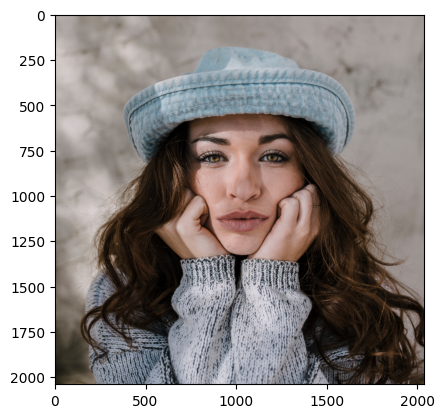

In [98]:
test_img = Image.open('/kaggle/working/DIV2K_valid_LR_bicubic/X2/0855x2.png')#replace with the path of an image

test_img = double_size(test_img)

plt.imshow(test_img)

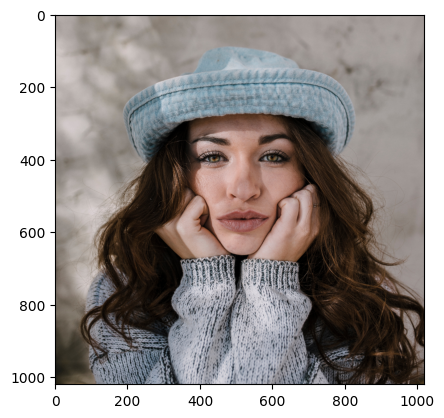

In [91]:
test_img = Image.open('/kaggle/working/DIV2K_valid_LR_bicubic/X2/0855x2.png')#replace with the path of an image


plt.imshow(test_img)